# **Знакомство с данными, обработка пропусков и выбросов**

Какие данные нам предоставили, чтобы мы могли выявить решающие факторы для успеха маркетинговой кампании? В целом их можно разделить на несколько групп.

**Данные о клиентах банка:**

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

**Прочие признаки:**

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).
* ***deposit*** наша целевая переменная, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

Начнём с того, что оценим, насколько предложенные данные готовы к дальнейшему анализу. В первую очередь давайте выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [178]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

### **Задание 2.1**

В каком признаке пропущенных значений больше всего?

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Вы успешно справились с предыдущим заданием и выяснили количество пропущенных значений. Однако в настоящих данных обычно всё не так просто, и пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости). Узнайте, каким именно словом закодированы пропущенные (неизвестные) значения.

### **Задание 2.2**

Введите слово, которым закодированы пропуски (неизвестные значения).

In [180]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

Обратите внимание на признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип float.

### **Задание 2.3**

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [181]:
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)

df['balance'].mean().round(3)

1529.129

Итак, значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

### **Задание 2.4**

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [182]:
median_balance = df['balance'].median()
df['balance'].fillna(median_balance, inplace=True)
df['balance'].mean().round(3)

1526.936

Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Замените все пропущенные значения в признаке job на модальные. То же самое сделайте с признаком, отвечающим за уровень образования.

### **Задание 2.5**

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [183]:
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]
df['job'] = df['job'].replace('unknown', mode_job)
df['education'] = df['education'].replace('unknown', mode_education)

df[(df['education']==mode_education) & (df['job']==mode_job)]['balance'].mean().round(3)

1598.883

Изучите признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха (Q1 - 1.5 * IQR) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (Q3 - 1.5 * IQR). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

*Примечание. Несмотря на то что существуют более продвинутые методы поиска аномальных значений, для обработки одного числового признака достаточно хорошо подходит метод Тьюки. После решения задачи вы сможете попробовать применить и другие методы, оценив их влияние на качество поиска.*

### **Задание 2.6**

Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

In [184]:
df_copy = df.copy()

In [185]:
df['balance'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11162 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB


In [186]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df_copy, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница по Тьюки: {lower_bound}')
print(f'Верхняя граница по Тьюки: {upper_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница по Тьюки: -2241.0
Верхняя граница по Тьюки: 4063.0


***
# **Разведывательный анализ данных**

✍ В данной части проекта вам необходимо будет:

* исследовать данные;
* попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;
* дополнить ваш анализ визуализациями, иллюстрирующими ваше исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.

Давайте изучим распределение целевой переменной: есть ли несбалансированность классов? Чтобы это определить, вычислите частоты для открывших депозит и для тех, кто его не открыл. Сопроводите числа диаграммой, отражающей полученные результаты.

### **Задание 3.1**

Сколько клиентов открыли депозит?

no     5424
yes    4681
Name: deposit, dtype: int64

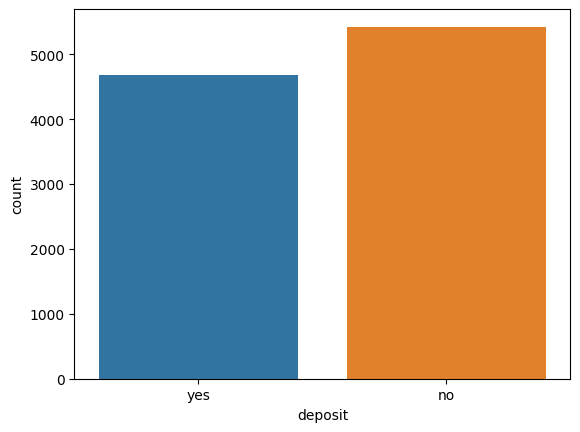

In [187]:
sns.countplot(data=cleaned, x='deposit');
cleaned['deposit'].value_counts()

Начнём с описательных статистик для количественных переменных.

* Рассчитайте их и продумайте подробную интерпретацию.
* Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
* Рассмотрите минимальные и максимальные значения.
* Посмотрите на меры разброса и оцените, насколько данные вариативны.
* Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
* Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

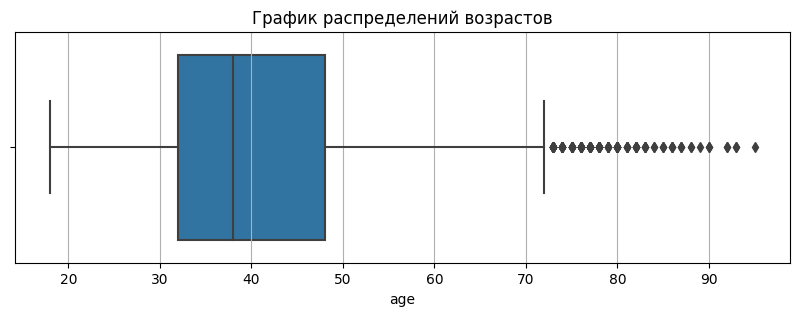

In [188]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 3))
ax1.set_title('График распределений возрастов')
plt.grid()
sns.boxplot(cleaned['age'], ax=ax1);
# описательные статистики
display(cleaned['age'].describe())

### **Задание 3.2**

Каков максимальный возраст клиента банка?

In [189]:
cleaned['age'].max()

95

### **Задание 3.3**

Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.

In [190]:
cleaned['duration'].min()

2

Теперь давайте рассмотрим описательные статистики для категориальных переменных.

Попробуйте извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

    Совет. Вопросы, приведённые выше, — это лишь пример того, что можно рассмотреть. Постарайтесь самостоятельно составить различные выводы и описать их. Сделайте информативные и красивые визуализации, дополняющие ваши выводы.

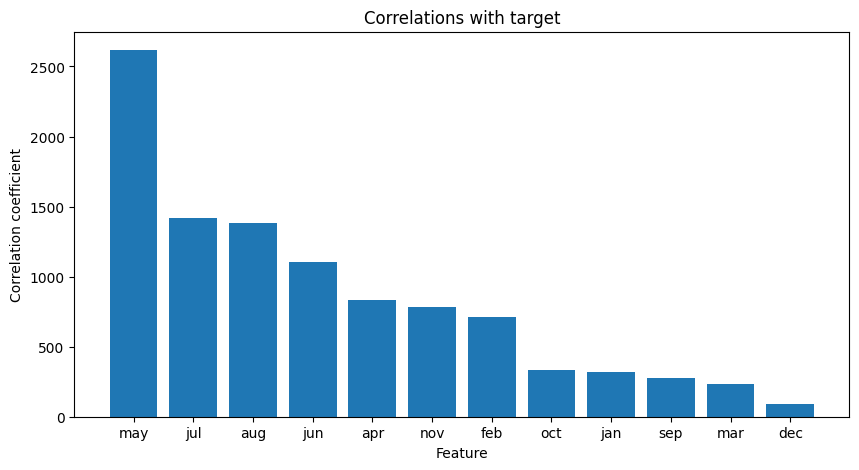

In [191]:
# Сколько всего сфер занятости представлено среди клиентов банка?
cleaned['job'].describe()
# В каждый ли месяц проходила маркетинговая кампания?
cleaned['month'].unique()
# Какое семейное положение встречается чаще всего?
cleaned['marital'].describe()
# Какое образование встречается чаще всего?
cleaned['education'].describe()

# подробная интерпретация
plot_data = pd.DataFrame(cleaned['month'].value_counts())
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(plot_data.index.tolist(), [item for sublist in plot_data.values.tolist() for item in sublist]) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

### **Задание 3.4**

Сколько было месяцев, в которых проводилась маркетинговая кампания?

In [192]:
12

12

### **Задание 3.5**

Сколько сфер занятости представлено среди клиентов банка?

In [193]:
# Сколько всего сфер занятости представлено среди клиентов банка?
cleaned['job'].describe()

count          10105
unique            11
top       management
freq            2315
Name: job, dtype: object

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, **для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач**.

### **Задание 3.6**

Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.

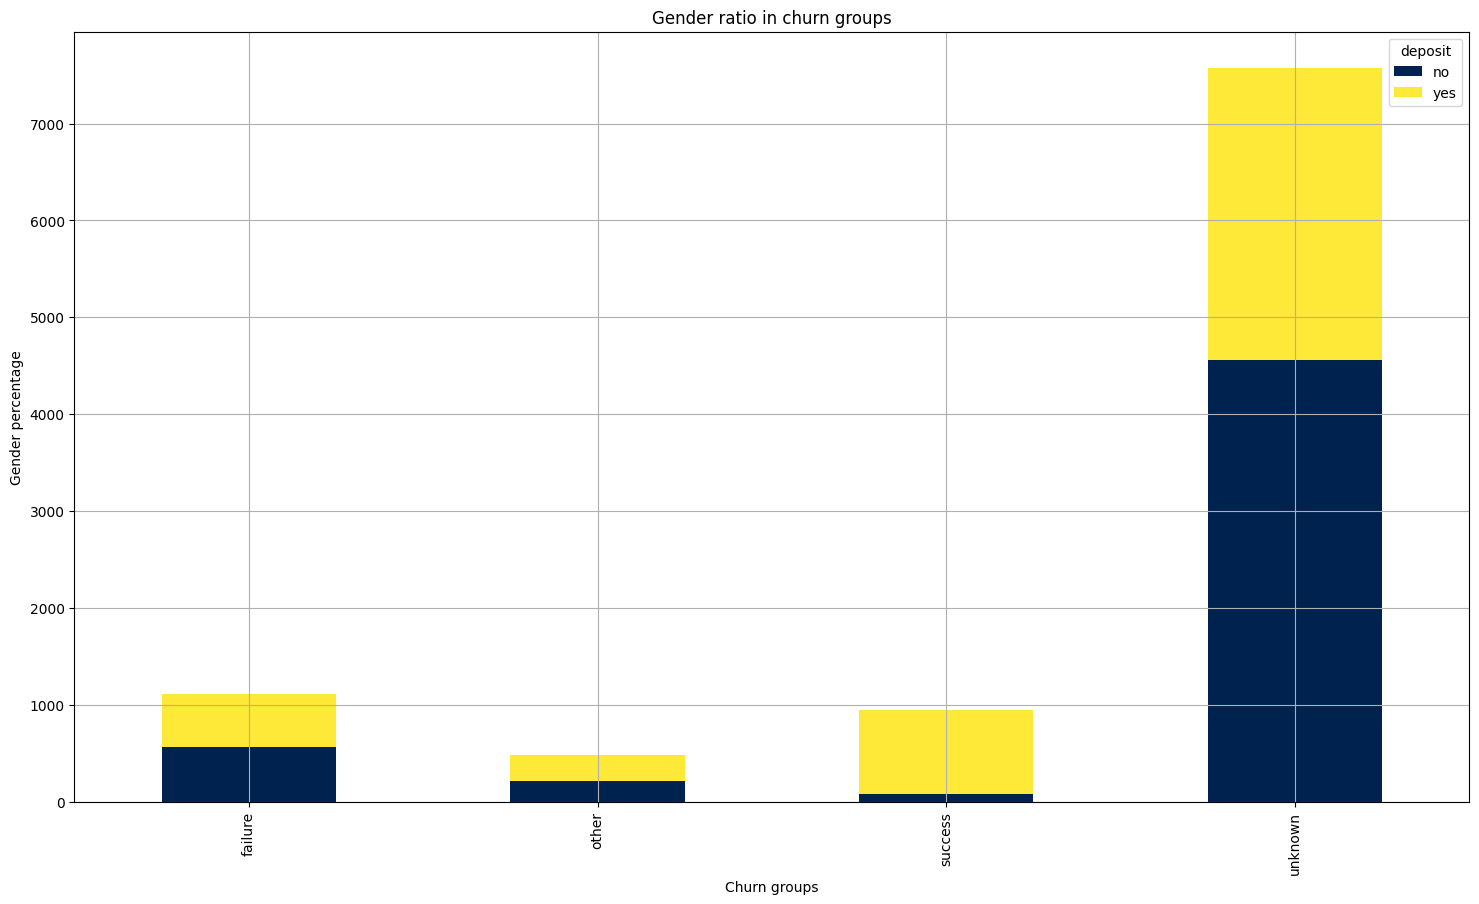

In [194]:
bar_data = cleaned.groupby(['poutcome'])['deposit'].value_counts().unstack(level=1)
bar_data.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 10),
    xlabel='Churn groups',
    ylabel='Gender percentage',
    #yticks=bar_data['Female'],
    colormap='cividis',
    grid=True,
    title='Gender ratio in churn groups'
);

Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

### **Задание 3.7**

Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

In [195]:
bar_data = cleaned.groupby(['month'])['deposit'].value_counts().sort_index()
list_of_percent = {}
sum = 0
for i in range(0,bar_data.shape[0],2):
    sum = bar_data[i]+bar_data[i+1]
    percentage = bar_data[i]/sum
    list_of_percent[bar_data.index[i]]=percentage
list_of_percent =pd.DataFrame(list_of_percent.items(), columns=['Month', 'Failure percentage'])
list_of_percent.sort_values(by='Failure percentage', ascending=False)

,Month,Failure percentage
8,"(may, no)",0.678640
4,"(jan, no)",0.608150
5,"(jul, no)",0.589563
9,"(nov, no)",0.584615
1,"(aug, no)",0.559567
6,"(jun, no)",0.548913
3,"(feb, no)",0.455571
0,"(apr, no)",0.381928
10,"(oct, no)",0.185075
11,"(sep, no)",0.165468


Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

* '<30';
* '30-40';
* '40-50';
* '50-60';
* '60+'.

Совет. После создания этой переменной постройте диаграмму (на ваш вкус), которая, с вашей точки зрения, сможет наилучшим образом отобразить различия в количестве открытых/не открытых депозитов для каждой возрастной группы.

### **Задание 3.8**

Выберите из списка две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

,Age group,Failure percentage
4,"(60+, no)",0.810916
0,"(<30, no)",0.562032
3,"(50-60, no)",0.425846
1,"(30-40, no)",0.423477
2,"(40-50, no)",0.396896


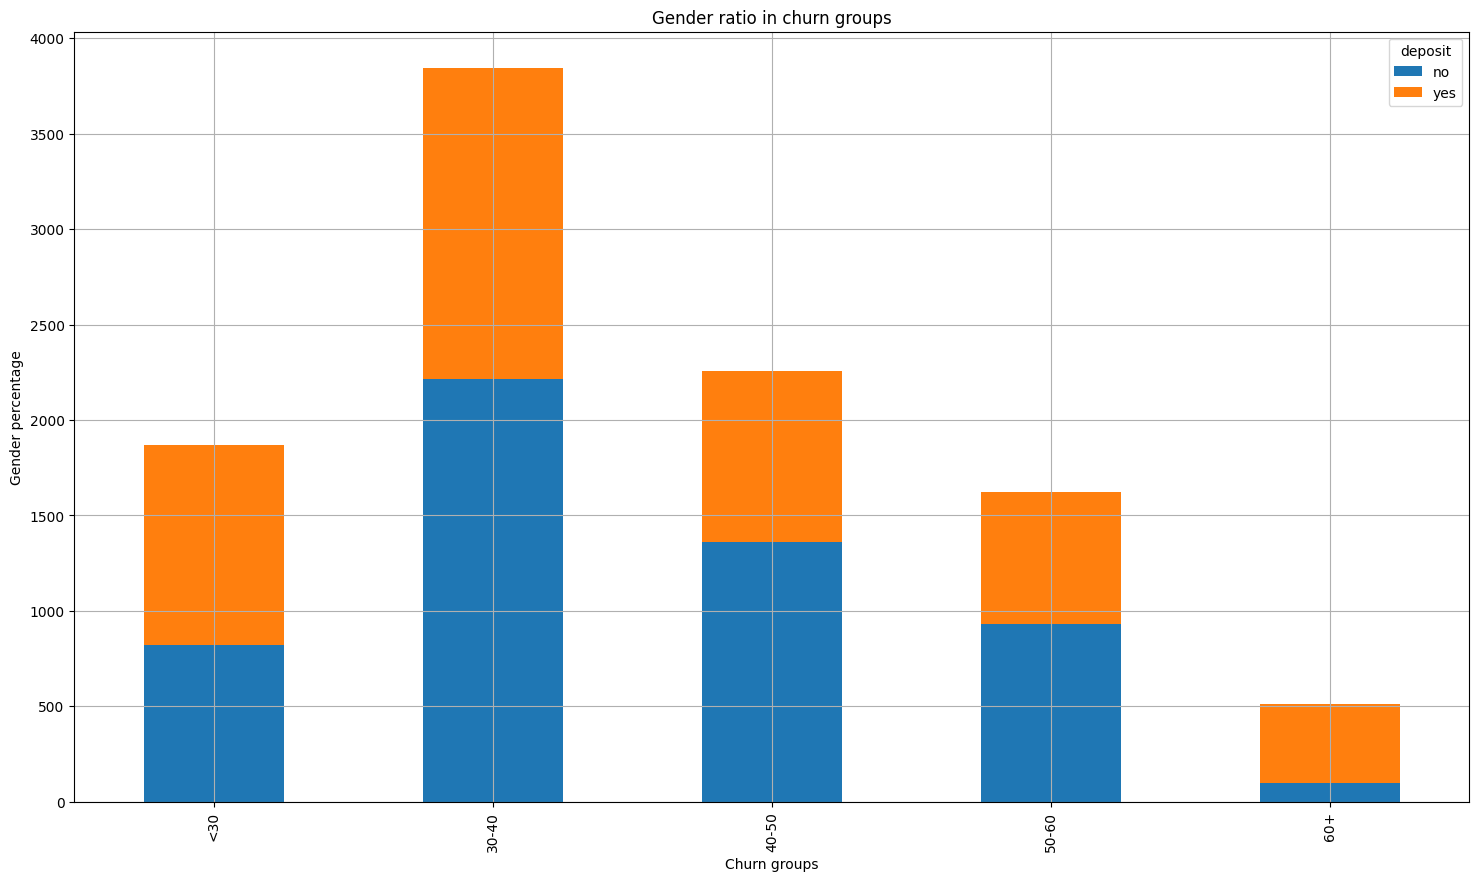

In [196]:
cleaned['age_group'] = pd.cut(cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
bar_data = cleaned.groupby(['age_group'])['deposit'].value_counts().sort_index()
list_of_percent = {}
sum = 0
for i in range(0,bar_data.shape[0],2):
    sum = bar_data[i]+bar_data[i+1]
    percentage = bar_data[i+1]/sum
    list_of_percent[bar_data.index[i]]=percentage
list_of_percent =pd.DataFrame(list_of_percent.items(), columns=['Age group', 'Failure percentage'])
display(list_of_percent.sort_values(by='Failure percentage', ascending=False))

# диаграмма
bar_data = bar_data.unstack(level=1)
bar_data.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 10),
    xlabel='Churn groups',
    ylabel='Gender percentage',
    grid=True,
    title='Gender ratio in churn groups'
);

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;
* уровень образования;
* сфера занятости.

Постройте визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.

К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

### **Задание 3.9**

В какой сфере занято наибольшее число клиентов банка?

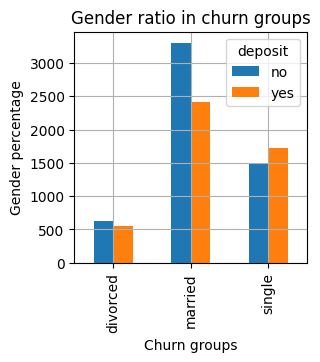

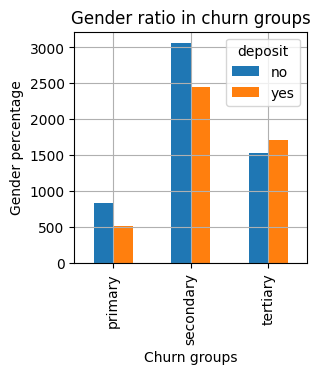

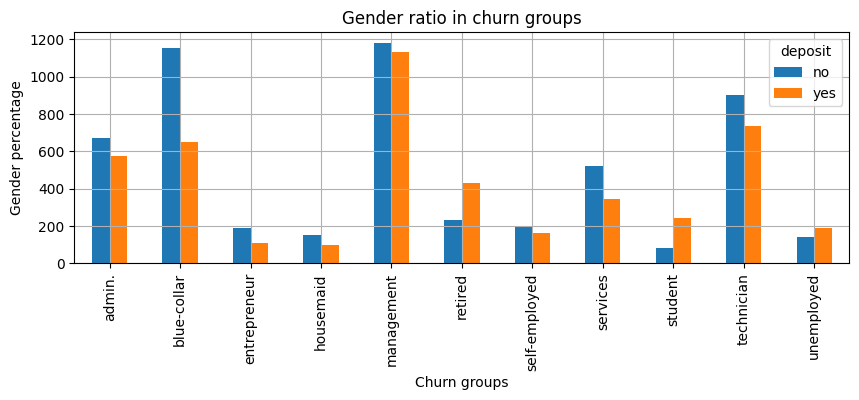

In [197]:
bar_data_marital = cleaned.groupby(['marital'])['deposit'].value_counts().sort_index().unstack(level=1)
bar_data_education = cleaned.groupby(['education'])['deposit'].value_counts().sort_index().unstack(level=1)
bar_data_job = cleaned.groupby(['job'])['deposit'].value_counts().sort_index().unstack(level=1)
bar_data_marital.plot(
    kind='bar',
    figsize=(3, 3),
    xlabel='Churn groups',
    ylabel='Gender percentage',
    grid=True,
    title='Gender ratio in churn groups'
);

bar_data_education.plot(
    kind='bar',
    figsize=(3, 3),
    xlabel='Churn groups',
    ylabel='Gender percentage',
    grid=True,
    title='Gender ratio in churn groups'
);

bar_data_job.plot(
    kind='bar',
    figsize=(10, 3),
    xlabel='Churn groups',
    ylabel='Gender percentage',
    grid=True,
    title='Gender ratio in churn groups'
);

В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

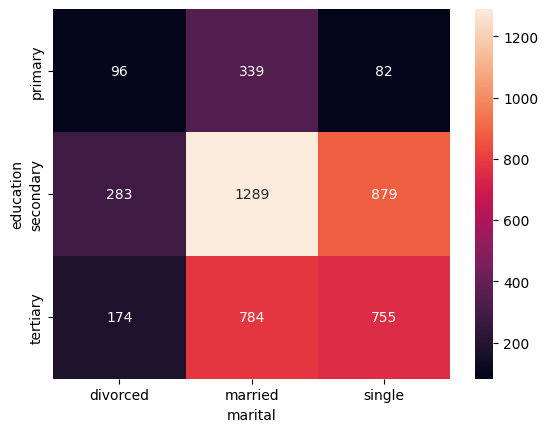

In [198]:
cleaned_yes =cleaned[cleaned['deposit']=='yes']
cleaned_no =cleaned[cleaned['deposit']=='no']

pivot_yes = pd.crosstab(cleaned_yes.education, cleaned_yes.marital)
pivot_yes.columns = pivot_yes.columns.astype('string') # не забыть переводить дату в нахваниях столбцов в стринг

pivot_no = pd.crosstab(cleaned_no.education, cleaned_no.marital)

heatmap = sns.heatmap(data=pivot_yes, annot=True,fmt=".0f")

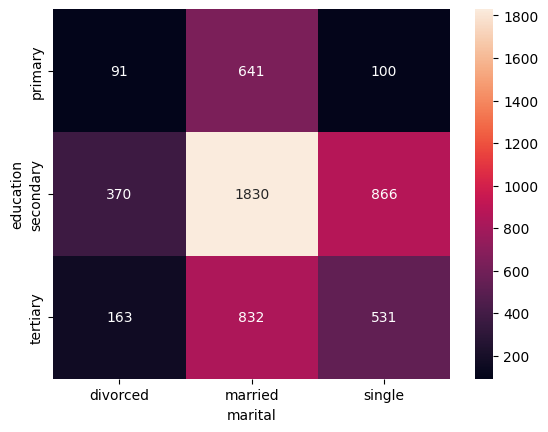

In [199]:
heatmap = sns.heatmap(data=pivot_no, annot=True,fmt=".0f")

***
# **Отбор и преобразование признаков**

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

* Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.
* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.
* Надо отобрать признаки, которые мы будем использовать для обучения модели.

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

Обработайте его с помощью метода LabelEncoder, используя метод без дополнительных настроек.

### **Задание 4.1**

Найдите сумму получившихся значений для признака education.

In [200]:
label_encoder = LabelEncoder()

cleaned['education'] = label_encoder.fit_transform(cleaned['education'])
cleaned['education'].sum()

11995

Ранее мы создали порядковую переменную для возраста. Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [201]:
cleaned['age_group'] = label_encoder.fit_transform(cleaned['age_group'])

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [202]:
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 0 if x=='no' else 1)
cleaned['deposit'].std().round(3)

0.499

Сделаем то же самое для других бинарных переменных, которых у нас три:

* 'default';
* 'housing';
* 'loan'.

Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [203]:
cleaned['default'] = cleaned['default'].apply(lambda x: 0 if x=='no' else 1)
cleaned['housing'] = cleaned['housing'].apply(lambda x: 0 if x=='no' else 1)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 0 if x=='no' else 1)

### **Задание 4.3**

Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

In [204]:
print((cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()).round(3))

0.635


Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

* 'job';
* 'marital';
* 'contact';
* 'month';
* 'poutcome'.

Создайте для них dummy-переменные и добавьте их в набор данных.

### **Задание 4.4**

Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

In [205]:
# get_dummies УДАЛЯЕТ исходные признаки
cleaned = pd.get_dummies(cleaned, prefix = ['job','marital','contact','month', 'poutcome'])

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

               index   deposit
11           deposit  1.000000
7           duration  0.457818
44  poutcome_success  0.288491
27  contact_cellular  0.223944
9              pdays  0.147917
10          previous  0.141102
3            balance  0.135893
37         month_mar  0.135348
12         age_group  0.133641
40         month_oct  0.130599
41         month_sep  0.125239
21       job_student  0.105563
18       job_retired  0.100090
1          education  0.098253
26    marital_single  0.097005


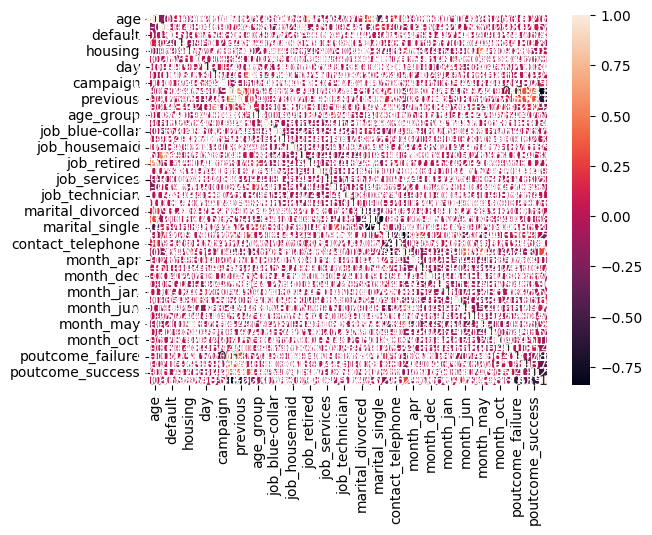

In [206]:
corr = cleaned.corr()
sns.heatmap(corr, annot = True);

new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
print(sort_corr.head(15))

Теперь вам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33. Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.

### **Задание 4.7**

Каким получился размер тестовой выборки?

In [207]:
X, y = cleaned.drop('deposit', axis=1), cleaned['deposit']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print('Train:\n', y_train.value_counts(), sep='')
print('Valid:\n', y_valid.value_counts(), sep='')
print(X_valid.shape[0])

Train:
0    3634
1    3136
Name: deposit, dtype: int64
Valid:
0    1790
1    1545
Name: deposit, dtype: int64
3335


### **Задание 4.8**

Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.

In [208]:
print(y_valid.mean().round(2))

0.46


На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

In [209]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
remained_cols = selector.get_feature_names_out().tolist()
print(remained_cols)

new_data = cleaned[remained_cols]
X_train_rem = X_train[remained_cols]
X_valid_rem = X_valid[remained_cols]

['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### **Задание 4.9**

Укажите одну переменную, не попавшую в данный перечень:

* month_mar
* month_may
* month_oct
* month_sep
* **month_jan**

Теперь данные необходимо нормализовать.

Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

Помните, что нормализация требуется для предикторов, а не для целевой переменной.

Нормализуйте предикторы в обучающей и тестовой выборках.

### **Задание 4.10**

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

In [213]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_rem)
X_train = scaler.transform(X_train_rem)
X_valid = scaler.transform(X_valid_rem)
print(round(X_valid[:,0].mean(),2))

0.47


***
# **Решение задачи классификации: логистическая регрессия и решающие деревья**

✍Настало время классификации!

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

In [214]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

#Делаем предсказание и смотрим метрику для тренировочной выборки
y_pred = log_reg.predict(X_train)
print('Accuracy Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred)))

#Делаем предсказание и смотрим метрику для тестовой выборки
y_pred = log_reg.predict(X_valid)
print('Accuracy Test: {:.2f}'.format(metrics.accuracy_score(y_valid, y_pred)))

Accuracy Train: 0.82
Accuracy Test: 0.81


### **Задание 5.1**

Для получившейся модели вычислите значение accuracy на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [215]:
#Делаем предсказание и смотрим метрику для тестовой выборки
y_pred = log_reg.predict(X_valid)
print('Accuracy Test: {:.2f}'.format(metrics.accuracy_score(y_valid, y_pred)))

Accuracy Test: 0.81


Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

* criterion = 'entropy';
* random_state = 42.

Остальные параметры оставьте по умолчанию.

### **Задание 5.2**

Что можно наблюдать после реализации алгоритма и оценки его качества?

In [216]:
#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)

dt.fit(X_train, y_train)
 
#Делаем предсказание класса для train
y_pred_dt = dt.predict(X_train)
print(metrics.classification_report(y_train, y_pred_dt))

#Делаем предсказание класса для test
y_pred_dt = dt.predict(X_valid)
print(metrics.classification_report(y_valid, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [217]:
#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=6,
    random_state=42 #генератор случайных чисел
)

dt.fit(X_train, y_train)
 
#Делаем предсказание класса для train
y_pred_dt = dt.predict(X_train)
print(metrics.classification_report(y_train, y_pred_dt))

#Делаем предсказание класса для test
y_pred_dt = dt.predict(X_valid)
print(metrics.classification_report(y_valid, y_pred_dt))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.77      0.86      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

* 'min_samples_split': [2, 5, 7, 10];
* 'max_depth':[3,5,7].

### **Задание 5.5**

Оцените метрику F1 на тестовой выборке для наилучшей комбинации перебираемых параметров. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [218]:
from sklearn.model_selection import GridSearchCV # класс GridSearchCV
from sklearn.model_selection import RandomizedSearchCV # RandomizedSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42), 
    param_grid=param_grid,
    n_jobs = -1
    )  

%time grid_search_tree.fit(X_train, y_train) 
print("Accuracy на тестовом наборе: {:.4f}".format(grid_search_tree.score(X_valid, y_valid)))
y_test_pred = grid_search_tree.predict(X_valid)
print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_valid, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 156 ms
Wall time: 3.39 s
Accuracy на тестовом наборе: 0.8135
f1_score на тестовом наборе: 0.8028
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


⭐ Прекрасно! По сути, вы уже решили задачу классификации: отобрали признаки, обучили модель, сделали прогноз и оценили его качество. Однако не будем останавливаться на достигнутом — попробуем более сложные модели и варианты оптимизации

***
# **Решение задачи классификации: ансамбли моделей и построение прогноза**

✍ Вы уже смогли обучить несложные модели, и теперь пришло время усложнить их, а также посмотреть, улучшится ли результат (если да, то насколько). Вы обучили решающие деревья, и теперь пришла пора объединить их в случайный лес.

Обучите случайный лес со следующими параметрами:

* n_estimators = 100;
* criterion = 'gini';
* min_samples_leaf = 5;
* max_depth = 10;
* random_state = 42.

### **Задание 6.1**

Оцените метрики accuracy и recall для построенной модели на тестовой выборке. В качестве ответов введите значения метрик. Ответ округлите до двух знаков после точки-разделителя.

In [219]:
#Создаём объект класса RandomForestClassifier
forest = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5,
    random_state=42 #генератор случайных чисел
)

#Обучаем модель
forest.fit(X_train, y_train)

#Делаем предсказание класса train
y_pred_train = forest.predict(X_train)
print(metrics.classification_report(y_train, y_pred_train))

#Делаем предсказание класса test
y_pred_test = forest.predict(X_valid)
print(metrics.recall_score(y_valid, y_pred_test).round(2))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

0.83


Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

* learning_rate = 0.05;
* n_estimators = 300;
* min_samples_leaf = 5;
* max_depth = 5;
* random_state = 42.

### **Задание 6.2**

Для построенной модели оцените метрику F1 на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [220]:
from sklearn.ensemble import GradientBoostingClassifier

# Инициализируем модель градиентного бустинга:
gb = GradientBoostingClassifier(
    #loss='deviance', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    min_samples_leaf=5,
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)

# Обучим её на тренировочной выборке:
gb.fit(X_train, y_train)

# Посмотрим на метрики классификации с помощью classification_report():
y_pred = gb.predict(X_valid)
print(metrics.f1_score(y_valid, y_pred).round(2))

0.82


Вы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

### **Задание 6.4**

Для построенной модели оцените метрику precision на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [221]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr', log_reg),
    ('dt', dt),
    ('gb', gb)
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
)
 
#Обучаем модель
reg.fit(X_train, y_train)

y_pred_stack = reg.predict(X_valid)
print(metrics.precision_score(y_valid, y_pred_stack).round(2))

0.81


Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

In [227]:
from sklearn.feature_selection import RFE

estimator = linear_model.LogisticRegression()
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train_rem, y_train)
 
selector.get_feature_names_out()
# 3 самых важных признака
print(X_train_rem.columns)
# сила влияния признаков
print(selector.ranking_)

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')
[15  6 12 10 13 14  9  7  5  2 11  4  3  1  8]


Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:

* n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
* max_depth = trial.suggest_int('max_depth', 10, 30, 1);
* min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

### **Задание 6.6**

Введите значение метрики F1 на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.

In [231]:
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [232]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-12 15:10:06,161] A new study created in memory with name: RandomForestClassifier
[I 2022-11-12 15:10:06,605] Trial 0 finished with value: 0.8922643282179769 and parameters: {'n_estimators': 101, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8922643282179769.
[I 2022-11-12 15:10:07,244] Trial 1 finished with value: 0.8537042825883089 and parameters: {'n_estimators': 174, 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8922643282179769.
[I 2022-11-12 15:10:07,949] Trial 2 finished with value: 0.9027799591644418 and parameters: {'n_estimators': 161, 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9027799591644418.
[I 2022-11-12 15:10:08,617] Trial 3 finished with value: 0.8608424336973479 and parameters: {'n_estimators': 177, 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9027799591644418.
[I 2022-11-12 15:10:09,039] Trial 4 finished with value: 0.8467703913248468 and parameters: {'n_

CPU times: total: 12.2 s
Wall time: 12.2 s


In [235]:
from sklearn import ensemble 
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_valid, y_valid)))
y_test_pred = model.predict(X_valid)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_valid, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
